CODE BLOCK: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_9")

In [ ]:
from utils import *
# from models import *

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [ ]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
#     transforms.Resize((28, 28)),
#     transforms.RandomRotation((-15., 15.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])

train_transforms = transforms.Compose(
    [transforms.RandomRotation((-15., 15.), fill=0),
     transforms.RandomCrop(size=[32,32], padding=4),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
     transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
     ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
     ])



CODE BLOCK: 4

In [ ]:
# train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.CIFAR10('../data', train=True, download=True)
# test_data = datasets.CIFAR10('../data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

In [ ]:
def plot_samples_cifar10_1(batch_data,batch_label,classes,unnorm):
  fig = plt.figure(figsize = (8,8))

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(unorm(batch_data[i]).permute(1,2,0))
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

torch.Size([3, 32, 32])


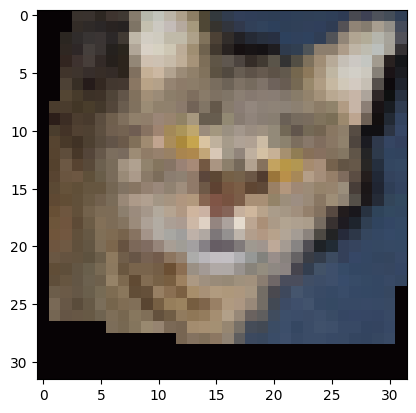

In [ ]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# batch_data, batch_label = next(iter(train_loader))
# new_img = unorm(batch_data[0])
# # new_img = batch_data[0] * (0.2470, 0.2435, 0.2616) + (0.4915, 0.4823, 0.4468)
# print(batch_data[0].shape)
# plt.imshow(batch_data[0].permute(1,2,0))
# plt.imshow(new_img.permute(1,2,0))


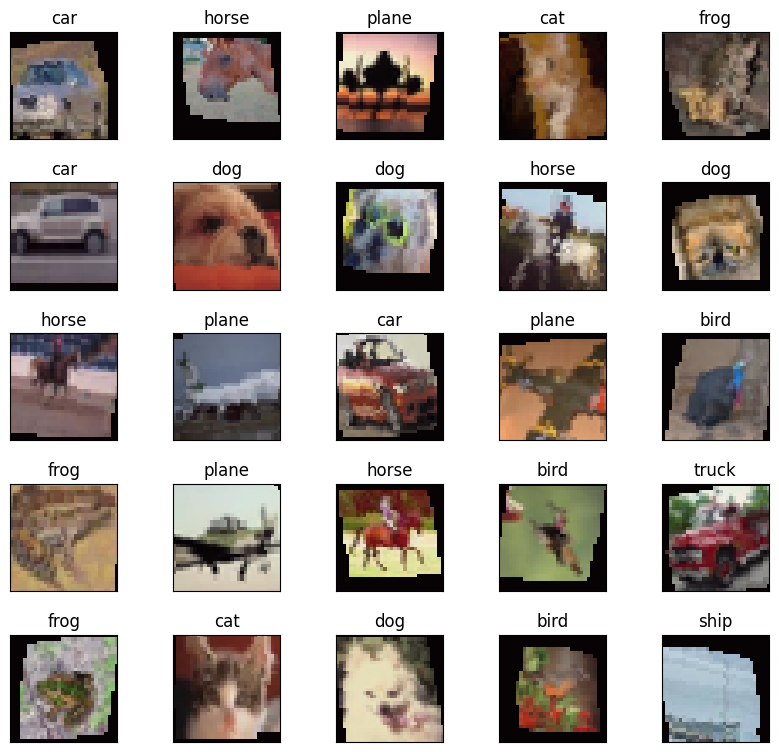

In [ ]:
import matplotlib.pyplot as plt
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10_1(batch_data,batch_label,classes,unorm)


In [ ]:
class s9_model_1(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(s9_model_1, self).__init__()
        self.conv1 = nn.Sequential(
                  nn.Conv2d(3, 32, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 32, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 32, 4, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32,32 , 3, padding=1, stride = 1, dilation = 1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 16, 1),
                  # nn.Dropout(0.10)
              )
        self.conv2 = nn.Sequential(
                  nn.Conv2d(16, 64, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(64, 64, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(64, 64, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(64, 64, 3, padding=1, stride = 2, dilation = 1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(64, 16, 1),
                  # nn.Dropout(0.10)
              )
        self.conv3 = nn.Sequential(
                  nn.Conv2d(16, 32, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 32, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 32, 3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(32, 32, 3, padding=1, stride = 2, dilation = 1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32),
                  nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(16),
                  nn.AvgPool2d(5,5),
                  nn.Conv2d(16, 10, 1),
              )

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        x = x.view(-1, 10)
        # x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s9_model_1().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 31, 31]          16,416
              ReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 32, 31, 31]           9,248
             ReLU-11           [-1, 32, 31, 31]               0
      BatchNorm2d-12           [-1, 32, 31, 31]              64
           Conv2d-13           [-1, 16, 31, 31]             528
           Conv2d-14           [-1, 64,

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.7013 Batch_id=97 Accuracy=27.53: 100%|██████████| 98/98 [00:36<00:00,  2.68it/s]


Test set: Average loss: 1.7050, Accuracy: 3609/10000 (36.09%)

Epoch 2


Train: Loss=1.3834 Batch_id=97 Accuracy=41.50: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 1.4993, Accuracy: 4459/10000 (44.59%)

Epoch 3


Train: Loss=1.3737 Batch_id=97 Accuracy=49.20: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 1.4250, Accuracy: 5081/10000 (50.81%)

Epoch 4


Train: Loss=1.1341 Batch_id=97 Accuracy=54.65: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 1.1536, Accuracy: 5858/10000 (58.58%)

Epoch 5


Train: Loss=1.1760 Batch_id=97 Accuracy=58.26: 100%|██████████| 98/98 [00:36<00:00,  2.66it/s]


Test set: Average loss: 1.0913, Accuracy: 6129/10000 (61.29%)

Epoch 6


Train: Loss=1.1304 Batch_id=97 Accuracy=61.02: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]


Test set: Average loss: 1.0014, Accuracy: 6388/10000 (63.88%)

Epoch 7


Train: Loss=0.9937 Batch_id=97 Accuracy=63.08: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]


Test set: Average loss: 1.0144, Accuracy: 6421/10000 (64.21%)

Epoch 8


Train: Loss=0.9081 Batch_id=97 Accuracy=64.70: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]


Test set: Average loss: 0.9243, Accuracy: 6796/10000 (67.96%)

Epoch 9


Train: Loss=0.9041 Batch_id=97 Accuracy=66.13: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.8630, Accuracy: 6996/10000 (69.96%)

Epoch 10


Train: Loss=0.9547 Batch_id=97 Accuracy=67.61: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.8707, Accuracy: 6923/10000 (69.23%)

Epoch 11


Train: Loss=0.8999 Batch_id=97 Accuracy=68.84: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Test set: Average loss: 0.8283, Accuracy: 7068/10000 (70.68%)

Epoch 12


Train: Loss=0.7612 Batch_id=97 Accuracy=69.80: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.8436, Accuracy: 7074/10000 (70.74%)

Epoch 13


Train: Loss=0.8437 Batch_id=97 Accuracy=70.79: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 0.8306, Accuracy: 7110/10000 (71.10%)

Epoch 14


Train: Loss=0.7581 Batch_id=97 Accuracy=71.49: 100%|██████████| 98/98 [00:36<00:00,  2.71it/s]


Test set: Average loss: 0.7245, Accuracy: 7428/10000 (74.28%)

Epoch 15


Train: Loss=0.8386 Batch_id=97 Accuracy=72.55: 100%|██████████| 98/98 [00:38<00:00,  2.56it/s]


Test set: Average loss: 0.7332, Accuracy: 7458/10000 (74.58%)

Epoch 16


Train: Loss=0.7749 Batch_id=97 Accuracy=73.07: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.6884, Accuracy: 7623/10000 (76.23%)

Epoch 17


Train: Loss=0.7013 Batch_id=97 Accuracy=73.78: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.6344, Accuracy: 7821/10000 (78.21%)

Epoch 18


Train: Loss=0.6664 Batch_id=97 Accuracy=74.26: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]


Test set: Average loss: 0.6657, Accuracy: 7702/10000 (77.02%)

Epoch 19


Train: Loss=0.6783 Batch_id=97 Accuracy=74.69: 100%|██████████| 98/98 [00:36<00:00,  2.68it/s]


Test set: Average loss: 0.6930, Accuracy: 7672/10000 (76.72%)

Epoch 20


Train: Loss=0.7257 Batch_id=97 Accuracy=75.54: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]


Test set: Average loss: 0.6316, Accuracy: 7862/10000 (78.62%)

Epoch 21


Train: Loss=0.5970 Batch_id=97 Accuracy=75.47: 100%|██████████| 98/98 [00:39<00:00,  2.45it/s]


Test set: Average loss: 0.6616, Accuracy: 7756/10000 (77.56%)

Epoch 22


Train: Loss=0.6863 Batch_id=97 Accuracy=76.23: 100%|██████████| 98/98 [00:36<00:00,  2.66it/s]


Test set: Average loss: 0.6384, Accuracy: 7824/10000 (78.24%)

Epoch 23


Train: Loss=0.8107 Batch_id=97 Accuracy=76.33: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Test set: Average loss: 0.6205, Accuracy: 7902/10000 (79.02%)

Epoch 24


Train: Loss=0.6997 Batch_id=97 Accuracy=76.92: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]


Test set: Average loss: 0.6006, Accuracy: 7936/10000 (79.36%)

Epoch 25


Train: Loss=0.6870 Batch_id=97 Accuracy=77.13: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.5917, Accuracy: 8022/10000 (80.22%)

Epoch 26


Train: Loss=0.6348 Batch_id=97 Accuracy=77.38: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]


Test set: Average loss: 0.6146, Accuracy: 7904/10000 (79.04%)

Epoch 27


Train: Loss=0.6337 Batch_id=97 Accuracy=78.03: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.5664, Accuracy: 8070/10000 (80.70%)

Epoch 28


Train: Loss=0.5520 Batch_id=97 Accuracy=78.06: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.5619, Accuracy: 8068/10000 (80.68%)

Epoch 29


Train: Loss=0.5683 Batch_id=97 Accuracy=78.31: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]


Test set: Average loss: 0.5646, Accuracy: 8141/10000 (81.41%)

Epoch 30


Train: Loss=0.6128 Batch_id=97 Accuracy=78.72: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.5676, Accuracy: 8122/10000 (81.22%)

Epoch 31


Train: Loss=0.7056 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Test set: Average loss: 0.5238, Accuracy: 8250/10000 (82.50%)

Epoch 32


Train: Loss=0.5784 Batch_id=97 Accuracy=79.23: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.5504, Accuracy: 8132/10000 (81.32%)

Epoch 33


Train: Loss=0.6057 Batch_id=97 Accuracy=79.43: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.5109, Accuracy: 8226/10000 (82.26%)

Epoch 34


Train: Loss=0.6389 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.5236, Accuracy: 8238/10000 (82.38%)

Epoch 35


Train: Loss=0.5788 Batch_id=97 Accuracy=79.70: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.5317, Accuracy: 8192/10000 (81.92%)

Epoch 36


Train: Loss=0.5487 Batch_id=97 Accuracy=79.89: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.5282, Accuracy: 8202/10000 (82.02%)

Epoch 37


Train: Loss=0.5473 Batch_id=97 Accuracy=80.05: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.5425, Accuracy: 8193/10000 (81.93%)

Epoch 38


Train: Loss=0.5933 Batch_id=97 Accuracy=80.05: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Test set: Average loss: 0.5022, Accuracy: 8310/10000 (83.10%)

Epoch 39


Train: Loss=0.5483 Batch_id=97 Accuracy=80.50: 100%|██████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.4951, Accuracy: 8324/10000 (83.24%)

Epoch 40


Train: Loss=0.5974 Batch_id=97 Accuracy=80.58: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 0.5187, Accuracy: 8253/10000 (82.53%)

Epoch 41


Train: Loss=0.5830 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.5222, Accuracy: 8220/10000 (82.20%)

Epoch 42


Train: Loss=0.5063 Batch_id=97 Accuracy=80.93: 100%|██████████| 98/98 [00:38<00:00,  2.56it/s]


Test set: Average loss: 0.5182, Accuracy: 8299/10000 (82.99%)

Epoch 43


Train: Loss=0.6696 Batch_id=97 Accuracy=81.33: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Test set: Average loss: 0.4717, Accuracy: 8403/10000 (84.03%)

Epoch 44


Train: Loss=0.5707 Batch_id=97 Accuracy=81.19: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


Test set: Average loss: 0.5041, Accuracy: 8338/10000 (83.38%)

Epoch 45


Train: Loss=0.5608 Batch_id=97 Accuracy=81.52: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.4918, Accuracy: 8380/10000 (83.80%)

Epoch 46


Train: Loss=0.5335 Batch_id=97 Accuracy=81.47: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 0.4687, Accuracy: 8447/10000 (84.47%)

Epoch 47


Train: Loss=0.4869 Batch_id=97 Accuracy=81.83: 100%|██████████| 98/98 [00:36<00:00,  2.67it/s]


Test set: Average loss: 0.4725, Accuracy: 8430/10000 (84.30%)

Epoch 48


Train: Loss=0.5487 Batch_id=97 Accuracy=81.70: 100%|██████████| 98/98 [00:36<00:00,  2.66it/s]


Test set: Average loss: 0.4749, Accuracy: 8385/10000 (83.85%)

Epoch 49


Train: Loss=0.4485 Batch_id=97 Accuracy=81.97: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.4675, Accuracy: 8458/10000 (84.58%)

Epoch 50


Train: Loss=0.4414 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.4511, Accuracy: 8509/10000 (85.09%)



CODE BLOCK: 11

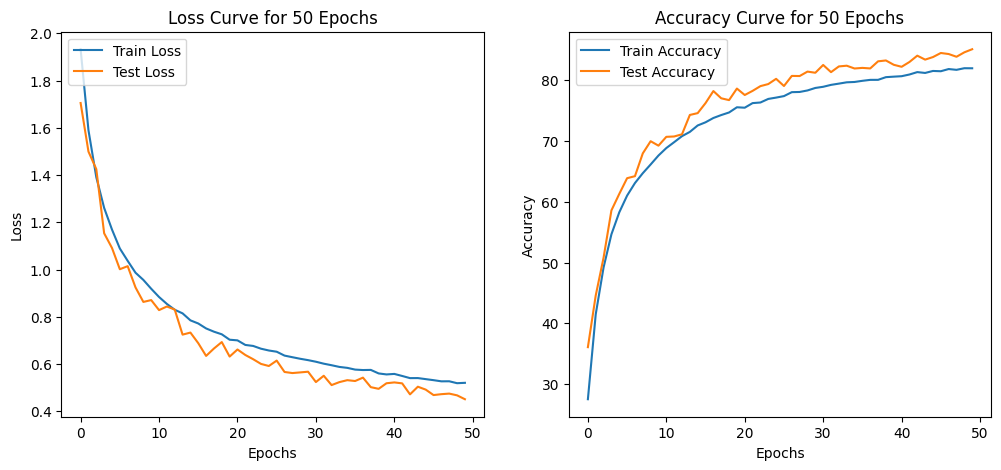

In [ ]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc,num_epochs)

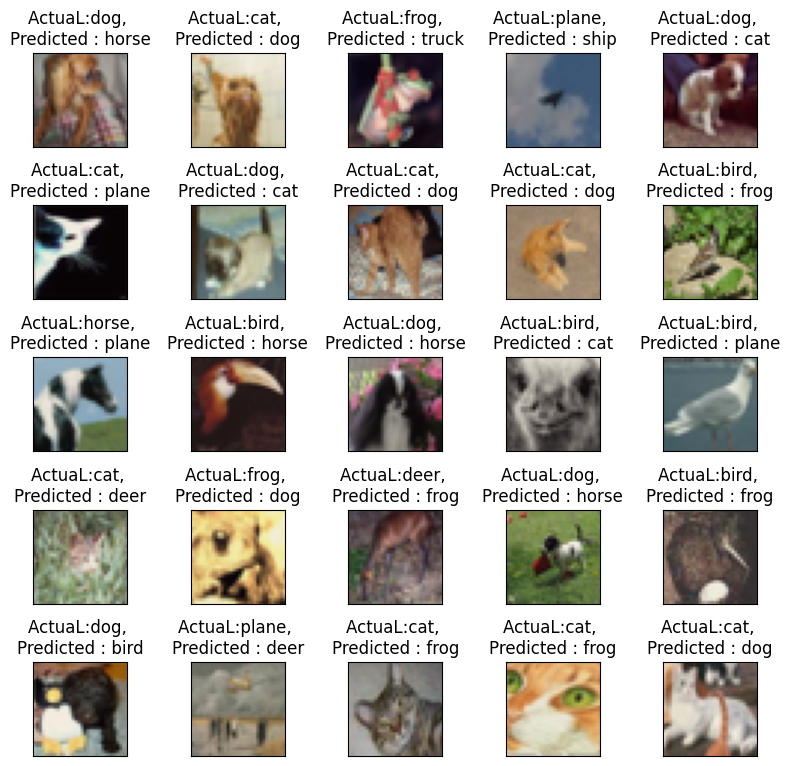

In [ ]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples_1(images, actual_label, predicted_label,classes,unorm)
  break


In [ ]:
def plot_misclassified_samples_1(batch_data,batch_label, pred_label,classes,unnorm):
  fig = plt.figure(figsize = (8,8))

  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(unnorm(batch_data[i]).permute(1,2,0))
    plt.title(f"ActuaL:{classes[batch_label[i]]}, \nPredicted : {classes[pred_label[i]]}")
    plt.xticks([])
    plt.yticks([])
  plt.show()